# Supervised Stylometric Analysis of the Pentateuch

### Table of Contents
1. [Introduction](#intro)
2. [Preprocess Data](#preprocess)  
3. [Algorithm Experimentation](#algo)  
4. [Prepare for Boosting](#boosting)  
5. [Boosting and Results](#result)


<a name='intro'></a>
### 1. Introduction
Modern biblical scholarship holds that the Pentateuch, also known as the Torah, is a multiauthor document that was composed over a period hundreds of years. However, scholars disagree on the number of and circumstance of the authors who have contributed to the Torah with some adhering to the older documentary hypothesis (DH) and many others prescribing to the newer, supplementary hypothesis (SH). This work aims to shed light on this controversy using Natural Language Processing (NLP) to identify the authors of the Torah at the sentence level. Computerized stylometric analysis in this piece reveals an intricate story showing the lack of a strong stylometric signature from the E source over the J source and a strong seepage of the P source into sources thought to be independent by the documentary hypothesis. 

In [1]:
import numpy as np
import pandas as pd 
import itertools

import fasttext
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn import ensemble, linear_model, metrics, model_selection, naive_bayes, svm
from gensim.models import Word2Vec, word2vec, KeyedVectors

import seaborn as sns
import matplotlib.pyplot as plt

color = sns.color_palette()
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
def runAlgo(algo, x_train, y_train, x_test, y_test, x2_test):
    """ 
    Helper function to simplify changing algorithms while testing.
    Only pass MNB, RF, LR, SVM as algo argument.
    Call runFastText and runXGB as a standalone.
    """
    
    return algo(x_train, y_train, x_test, y_test, x2_test)

In [3]:
def runMNB(x_train, y_train, x_test, y_test, x2_test):
    
    model = naive_bayes.MultinomialNB()
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [4]:
def runRandomForest(x_train, y_train, x_test, y_test, x2_test):
    
    model = ensemble.RandomForestClassifier(n_estimators=500, n_jobs=-1)
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [5]:
def runLogisticRegression(x_train, y_train, x_test, y_test, x2_test):
    
    model = linear_model.LogisticRegression(max_iter=10000)
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [6]:
def runSVM(x_train, y_train, x_test, y_test, x2_test):
    
    model = CalibratedClassifierCV(svm.SVC(kernel='poly', degree=4))
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [7]:
def runFastText(k, x_train, y_train, x_test, y_test, x2_test):
    
    f = open('fasttext_data.txt', 'w')
    for x, y in zip(x_train, y_train):
        line = '__label__' + str(y) + ' ' + x + '\n'
        f.write(line)
    f.close()

    model = fasttext.train_supervised(input='fasttext_data.txt', epoch=50, lr=1, wordNgrams=20,  minn=3, maxn=6, dim=100)
    
    y_pred_test = []
    labels, probs = model.predict(x_test, k=k)
    for label, prob in zip(labels, probs):
        p = [x for _, x in sorted(zip(label, prob))]
        y_pred_test.append(p)
    y_pred_test = np.array(y_pred_test)
    
    y2_pred_test = []
    labels, probs = model.predict(x2_test, k=k)
    for label, prob in zip(labels, probs):
        p = [x for _, x in sorted(zip(label, prob))]
        y2_pred_test.append(p)
    y2_pred_test = np.array(y2_pred_test)
    
    return y_pred_test, y2_pred_test, model

In [8]:
def runXGB(k, num_rounds, param, x_train, y_train, x_test, y_test=None, x2_test=None):
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)

    if y_test is not None:
        xgtest = xgb.DMatrix(x_test, label=y_test)
        watchlist = [(xgtrain,'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(x_test)
        model = xgb.train(plst, xgtrain, num_rounds)

    y_pred_test = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if x2_test is not None:
        xgtest2 = xgb.DMatrix(x2_test)
        y2_pred_test = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return y_pred_test, y2_pred_test, model

In [9]:
def word_vector(model, tokens, dim):
    """ 
    Generate a word vector.
    model: a completed model
    tokens: a list of words (in this case POS)
    dim: Number of dimensions. 100 - 300 is good for w2v
    """
    
    i = 0
    vec = np.zeros(dim).reshape((1, dim))
    for word in tokens:
        vec += model[word].reshape((1, dim))
        i += 1.
    if i != 0:
        vec /= i
    return vec

In [10]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<a name='preprocess'></a>
### 2. Preprocess Data

We omit the book of Deuteronomy in this study because both the DH and SH agree that it is a largely independent source with very minimal intrusion from the sources found in Genesis, Exodus, Leviticus, and Numbers. From a schollarly point of view, it is more closely related to the Deuteronomistic histories such as Joshua, Judges, Samuel, and Kings than it is to the rest of the Torah anyway. Classification performance could potentially decrease with each additional author, k. To give ourselves the best possible chance of success we will remove this book as there is minimal ongoing debate about its nature. 

In [11]:
df = pd.read_csv('data.csv')
print(df.loc[267, 'hebrew'])
print()
df = df[df['book'] != 'Deuteronomy']
df.head()

וֽ͏ַיְהִ֥י כָל־ הָאָ֖רֶץ שָׂפָ֣ה אֶחָ֑ת וּדְבָרִ֖ים אֲחָדִֽים׃



,Unnamed: 0,book,book_num,chapter,verse,hebrew,heb_no_niqquid_punct,web,pos,dh_author,sh_author
0,0,Genesis,1,1,1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,בראשית ברא אלהים את השמים ואת הארץ,"In the beginning God{After ""God,"" the Hebrew h...",prep subs.f.sg.a verb.qal.perf.p3.m.sg subs.m....,P,P
1,1,Genesis,1,1,2,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,והארץ היתה תהו ובהו וחשך על פני תהום ורוח אלהי...,Now the earth was formless and empty. Darkness...,conj art subs.u.sg.a verb.qal.perf.p3.f.sg sub...,P,P
2,2,Genesis,1,1,3,וַיֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י א֑וֹר וַֽיְהִי־ אֽ...,ויאמר אלהים יהי אור ויהי אור,"God said, ""Let there be light,"" and there was ...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a verb.qa...,P,P
3,3,Genesis,1,1,4,וַיַּ֧רְא אֱלֹהִ֛ים אֶת־ הָא֖וֹר כִּי־ ט֑וֹב ו...,וירא אלהים את האור כי טוב ויבדל אלהים בין האור...,"God saw the light, and saw that it was good. G...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a prep ar...,P,P
4,4,Genesis,1,1,5,וַיִּקְרָ֨א אֱלֹהִ֤ים ׀ לָאוֹר֙ י֔וֹם וְלַחֹ֖ש...,ויקרא אלהים לאור יום ולחשך קרא לילה ויהי ערב ו...,"God called the light Day, and the darkness he ...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a prep ar...,P,P


In this study we use Hebrew parts of speech embeddings as our input data for our classifers. The only data actually processed in the dataframe is the pos column, along with dh_author and sh_author which are converted to numerical format. 

In [12]:
df = shuffle(df, random_state=5780)

/home/cmd/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


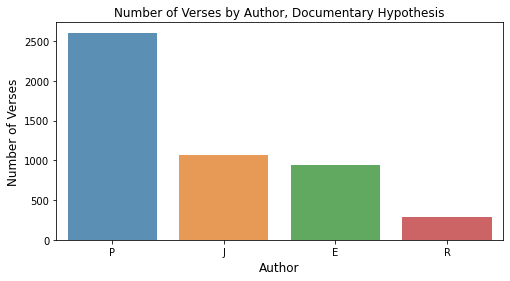

In [13]:
cnt_srs = df['dh_author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Verses', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Number of Verses by Author, Documentary Hypothesis')
plt.show()

/home/cmd/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


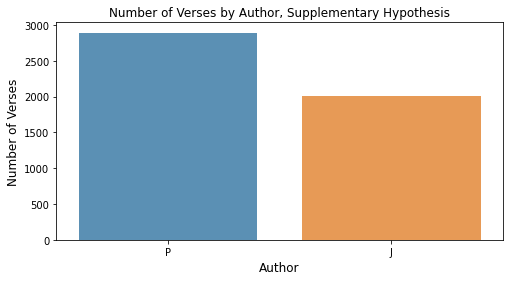

In [14]:
cnt_srs = df['sh_author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Verses', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.title('Number of Verses by Author, Supplementary Hypothesis')
plt.show()

In [15]:
# Create true labels
pos = df['pos'].tolist()
heb = df['heb_no_niqquid_punct'].tolist()
dh_author = df['dh_author']
sh_author = df['sh_author']

dh_to_int = {
    'J': 0,
    'E': 1,
    'P': 2, 
    'R': 3,
}
dh_labels = []
for label in dh_author:
    dh_labels.append(dh_to_int[label])
df['dh_labels'] = dh_labels
dh_labels = np.array(dh_labels)

sh_to_int = {
    'J': 0,
    'P': 1, 
}
sh_labels = []
for label in sh_author:
    sh_labels.append(sh_to_int[label])
df['sh_labels'] = sh_labels
sh_labels = np.array(sh_labels)

In [16]:
train_sh_df = pd.DataFrame()
train_dh_df = pd.DataFrame()
test_sh_df = pd.DataFrame()
test_dh_df = pd.DataFrame()

In [17]:
x_train, x_test, y_dh_train, y_dh_test = train_test_split(pos, dh_labels, test_size=0.2, random_state=5780)
x_train, x_test, y_sh_train, y_sh_test = train_test_split(pos, sh_labels, test_size=0.2, random_state=5780)

<a name='algo'></a>
### 3. Algorithm Experimentation

Lets generate some of the embeddings used throught the study and test them on various classification algorithms. None of the algorithms run here will be put through XGBoost, they are just used to get a glimpse at how performant each classifer is.

In [18]:
tfidf_vec = TfidfVectorizer(ngram_range=(2, 2))
full_tfidf = tfidf_vec.fit_transform(pos)
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [19]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

Mean cv log loss:  0.413796312824099
Mean cv accuracy:  0.8250319284802042


In [20]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

Mean cv log loss:  0.7992417994195782
Mean cv accuracy:  0.6646232439335887


In [21]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runLogisticRegression

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

Mean cv log loss:  0.4428418781390036
Mean cv accuracy:  0.801787994891443


In [22]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runMNB

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

Mean cv log loss:  0.5067597086632247
Mean cv accuracy:  0.7614303959131545


In [23]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runSVM

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

Mean cv log loss:  0.3722946303809612
Mean cv accuracy:  0.8393358876117496


In [24]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runFastText

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev = [x_train[idx] for idx in dev_index]
    x_val = [x_train[idx] for idx in val_index]
    y_dev = [y_train[idx] for idx in dev_index]
    y_val = [y_train[idx] for idx in val_index]
    y_pred_val, y_pred_test, model = runFastText(k, x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

Mean cv log loss:  0.44699773520215286
Mean cv accuracy:  0.8431673052362708


<a name='boosting'></a>
### 4. Prepare for Boosting

From here on out all embeddings and classifications will be used towards the XGBoost algorithm at the end of the notebook. All classification tasks will be performed twice, once where k=4 for the DH and once where k=2 for the SH.

In [25]:
tfidf_vec = TfidfVectorizer(ngram_range=(2, 2))
full_tfidf = tfidf_vec.fit_transform(pos)
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [26]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runSVM

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['svm_tfidf_j'] = pred_train[:, 0]
train_dh_df['svm_tfidf_e'] = pred_train[:, 1]
train_dh_df['svm_tfidf_p'] = pred_train[:, 2]
train_dh_df['svm_tfidf_r'] = pred_train[:, 3]
test_dh_df['svm_tfidf_j'] = pred_full_test[:, 0]
test_dh_df['svm_tfidf_e'] = pred_full_test[:, 1]
test_dh_df['svm_tfidf_p'] = pred_full_test[:, 2]
test_dh_df['svm_tfidf_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.8406469170354937
Mean cv accuracy:  0.6853128991060025


In [27]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runSVM

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['svm_tfidf_j'] = pred_train[:, 0]
train_sh_df['svm_tfidf_p'] = pred_train[:, 1]
test_sh_df['svm_tfidf_j'] = pred_full_test[:, 0]
test_sh_df['svm_tfidf_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.3722946303809612
Mean cv accuracy:  0.8393358876117496


TruncatedSVD is used to capture that extra little bit of style. The results from this are used in XGBoost and tend to decrease log loss. Capturing as much variance as possible is important. More variance can be captured by increase the number of components at the cost of compute time.

In [28]:
n_comp = 150

svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train_sh_df = pd.concat([train_sh_df, train_svd], axis=1)
train_dh_df = pd.concat([train_dh_df, train_svd], axis=1)
test_sh_df = pd.concat([test_sh_df, test_svd], axis=1)
test_dh_df = pd.concat([test_dh_df, test_svd], axis=1)

var_explained = svd_obj.explained_variance_ratio_.sum()
print('Variance Captured ', var_explained)

Variance Captured  0.9807547294520417


In [29]:
tfidf_vec = CountVectorizer(ngram_range=(1, 3))
full_tfidf = tfidf_vec.fit_transform(pos)
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [30]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['rf_cvec_j'] = pred_train[:, 0]
train_dh_df['rf_cvec_e'] = pred_train[:, 1]
train_dh_df['rf_cvec_p'] = pred_train[:, 2]
train_dh_df['rf_cvec_r'] = pred_train[:, 3]
test_dh_df['rf_cvec_j'] = pred_full_test[:, 0]
test_dh_df['rf_cvec_e'] = pred_full_test[:, 1]
test_dh_df['rf_cvec_p'] = pred_full_test[:, 2]
test_dh_df['rf_cvec_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.8013224536194444
Mean cv accuracy:  0.676117496807152


In [31]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['rf_cvec_j'] = pred_train[:, 0]
train_sh_df['rf_cvec_p'] = pred_train[:, 1]
test_sh_df['rf_cvec_j'] = pred_full_test[:, 0]
test_sh_df['rf_cvec_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.4042620874966071
Mean cv accuracy:  0.8263090676883781


In [32]:
tfidf_vec = CountVectorizer(ngram_range=(1, 25), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(pos)
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [33]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['rf_cvec_char_j'] = pred_train[:, 0]
train_dh_df['rf_cvec_char_e'] = pred_train[:, 1]
train_dh_df['rf_cvec_char_p'] = pred_train[:, 2]
train_dh_df['rf_cvec_char_r'] = pred_train[:, 3]
test_dh_df['rf_cvec_char_j'] = pred_full_test[:, 0]
test_dh_df['rf_cvec_char_e'] = pred_full_test[:, 1]
test_dh_df['rf_cvec_char_p'] = pred_full_test[:, 2]
test_dh_df['rf_cvec_char_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.772972847755223
Mean cv accuracy:  0.6865900383141763


In [34]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['rf_cvec_char_j'] = pred_train[:, 0]
train_sh_df['rf_cvec_char_p'] = pred_train[:, 1]
test_sh_df['rf_cvec_char_j'] = pred_full_test[:, 0]
test_sh_df['rf_cvec_char_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.3904189641371169
Mean cv accuracy:  0.8347381864623244


In [35]:
tfidf_vec = TfidfVectorizer(ngram_range=(5, 5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(pos)
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [36]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runSVM

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['svm_tfidf_char_j'] = pred_train[:, 0]
train_dh_df['svm_tfidf_char_e'] = pred_train[:, 1]
train_dh_df['svm_tfidf_char_p'] = pred_train[:, 2]
train_dh_df['svm_tfidf_char_r'] = pred_train[:, 3]
test_dh_df['svm_tfidf_char_j'] = pred_full_test[:, 0]
test_dh_df['svm_tfidf_char_e'] = pred_full_test[:, 1]
test_dh_df['svm_tfidf_char_p'] = pred_full_test[:, 2]
test_dh_df['svm_tfidf_char_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.8143192301072434
Mean cv accuracy:  0.7006385696040869


In [37]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runSVM

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['svm_tfidf_char_j'] = pred_train[:, 0]
train_sh_df['svm_tfidf_char_p'] = pred_train[:, 1]
test_sh_df['svm_tfidf_char_j'] = pred_full_test[:, 0]
test_sh_df['svm_tfidf_char_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.3494628737583154
Mean cv accuracy:  0.8549169859514688


In [38]:
n_comp = 150
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train_dh_df = pd.concat([train_dh_df, train_svd], axis=1)
train_sh_df = pd.concat([train_sh_df, train_svd], axis=1)
test_dh_df = pd.concat([test_dh_df, test_svd], axis=1)
test_sh_df = pd.concat([test_sh_df, test_svd], axis=1)

var_explained = svd_obj.explained_variance_ratio_.sum()
print('Variance Captured: ', var_explained)

Variance Captured:  0.973138868196565


In [39]:
dim = 300
w2v_sg_model = word2vec.Word2Vec(sentences=pos, vector_size=dim, window=100, shrink_windows=True, min_count=5, sg=1, hs=0, negative=0, workers=12, seed=5780)

wordvec_arrs = np.zeros((len(pos), dim)) 
for i in range(len(pos)):
    wordvec_arrs[i,:] = word_vector(w2v_sg_model.wv, pos[i], dim)
wordvec_df = pd.DataFrame(wordvec_arrs)
x_w2v_sg_train, x_w2v_sg_test = train_test_split(wordvec_df, test_size=0.2, random_state=5780)

In [40]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_w2v_sg_train):
    x_dev = x_w2v_sg_train.iloc[dev_index]
    x_val = x_w2v_sg_train.iloc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_sg_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['rf_w2v_sg_j'] = pred_train[:, 0]
train_dh_df['rf_w2v_sg_e'] = pred_train[:, 1]
train_dh_df['rf_w2v_sg_p'] = pred_train[:, 2]
train_dh_df['rf_w2v_sg_r'] = pred_train[:, 3]
test_dh_df['rf_w2v_sg_j'] = pred_full_test[:, 0]
test_dh_df['rf_w2v_sg_e'] = pred_full_test[:, 1]
test_dh_df['rf_w2v_sg_p'] = pred_full_test[:, 2]
test_dh_df['rf_w2v_sg_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.8682239074298096
Mean cv accuracy:  0.6444444444444445


In [41]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_w2v_sg_train):
    x_dev = x_w2v_sg_train.iloc[dev_index]
    x_val = x_w2v_sg_train.iloc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_sg_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['rf_w2v_sg_j'] = pred_train[:, 0]
train_sh_df['rf_w2v_sg_p'] = pred_train[:, 1]
test_sh_df['rf_w2v_sg_j'] = pred_full_test[:, 0]
test_sh_df['rf_w2v_sg_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.45949908552257257
Mean cv accuracy:  0.7989782886334611


In [42]:
dim = 300
w2v_cbow_model = word2vec.Word2Vec(sentences=pos, vector_size=dim, window=100, shrink_windows=True, min_count=5, sg=0, hs=0, negative=5, workers=12, seed=5780)

wordvec_arrs = np.zeros((len(pos), dim)) 
for i in range(len(pos)):
    wordvec_arrs[i,:] = word_vector(w2v_cbow_model.wv, pos[i], dim)
wordvec_df = pd.DataFrame(wordvec_arrs)
x_w2v_cbow_train, x_w2v_cbow_test = train_test_split(wordvec_df, test_size=0.2, random_state=5780)

In [43]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_w2v_cbow_train):
    x_dev = x_w2v_cbow_train.iloc[dev_index]
    x_val = x_w2v_cbow_train.iloc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_cbow_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['rf_w2v_cbow_j'] = pred_train[:, 0]
train_dh_df['rf_w2v_cbow_e'] = pred_train[:, 1]
train_dh_df['rf_w2v_cbow_p'] = pred_train[:, 2]
train_dh_df['rf_w2v_cbow_r'] = pred_train[:, 3]
test_dh_df['rf_w2v_cbow_j'] = pred_full_test[:, 0]
test_dh_df['rf_w2v_cbow_e'] = pred_full_test[:, 1]
test_dh_df['rf_w2v_cbow_p'] = pred_full_test[:, 2]
test_dh_df['rf_w2v_cbow_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.8744362874629268
Mean cv accuracy:  0.6424010217113665


In [44]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runRandomForest

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_w2v_cbow_train):
    x_dev = x_w2v_cbow_train.iloc[dev_index]
    x_val = x_w2v_cbow_train.iloc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_cbow_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['rf_w2v_cbow_j'] = pred_train[:, 0]
train_sh_df['rf_w2v_cbow_p'] = pred_train[:, 1]
test_sh_df['rf_w2v_cbow_j'] = pred_full_test[:, 0]
test_sh_df['rf_w2v_cbow_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.45538188314932454
Mean cv accuracy:  0.791060025542784


In [45]:
k = 4
n_splits = 5
y_train = y_dh_train
algo = runFastText

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev = [x_train[idx] for idx in dev_index]
    x_val = [x_train[idx] for idx in val_index]
    y_dev = [y_train[idx] for idx in dev_index]
    y_val = [y_train[idx] for idx in val_index]
    y_pred_val, y_pred_test, model = runFastText(k, x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_dh_df['fasttext_j'] = pred_train[:, 0]
train_dh_df['fasttext_e'] = pred_train[:, 1]
train_dh_df['fasttext_p'] = pred_train[:, 2]
train_dh_df['fasttext_r'] = pred_train[:, 3]
test_dh_df['fasttext_j'] = pred_full_test[:, 0]
test_dh_df['fasttext_e'] = pred_full_test[:, 1]
test_dh_df['fasttext_p'] = pred_full_test[:, 2]
test_dh_df['fasttext_r'] = pred_full_test[:, 3]

Mean cv log loss:  0.8580622358280673
Mean cv accuracy:  0.6957854406130268


In [46]:
k = 2
n_splits = 5
y_train = y_sh_train
algo = runFastText

cv_log_loss = []
cv_accuracy = []
pred_full_test = 0
pred_train = np.zeros([len(x_train), k])
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
for dev_index, val_index in kf.split(x_train):
    x_dev = [x_train[idx] for idx in dev_index]
    x_val = [x_train[idx] for idx in val_index]
    y_dev = [y_train[idx] for idx in dev_index]
    y_val = [y_train[idx] for idx in val_index]
    y_pred_val, y_pred_test, model = runFastText(k, x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
pred_full_test = pred_full_test / n_splits
print('Mean cv log loss: ', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

train_sh_df['fasttext_j'] = pred_train[:, 0]
train_sh_df['fasttext_p'] = pred_train[:, 1]
test_sh_df['fasttext_j'] = pred_full_test[:, 0]
test_sh_df['fasttext_p'] = pred_full_test[:, 1]

Mean cv log loss:  0.44675141100802024
Mean cv accuracy:  0.8424010217113664


<a name='result'></a>
### 5. Boosting and Results
XGBoost is optimized for each hypothesis using this guide https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [47]:
k = 4
n_splits = 5
y_train = y_dh_train
x_train = train_dh_df
x_test = test_dh_df
algo = runXGB

num_rounds = 2000
param = {
    'tree_method': 'gpu_hist',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': k,
    'eta': 0.05,
    'max_depth': 2,
    'min_child_weight': 2,
    'subsample': 1,
    'colsample_bytree': 0.6,
    'seed': 5780
}

y_dh_vals = []
cv_log_loss = []
cv_accuracy = []
cnf_dh_matrices = []
pred_full_test = 0
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
pred_train = np.zeros([len(x_train), k])
for dev_index, val_index in kf.split(x_train):
    x_dev, x_val = x_train.loc[dev_index], x_train.loc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runXGB(k, num_rounds, param, x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    cnf_matrix = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1))
    cnf_dh_matrices.append(cnf_matrix)
    y_dh_vals.append(y_val)
print('cv log loss : ', cv_log_loss)
print('cv accuracy: ', cv_accuracy)
print('Mean cv log loss:', np.mean(cv_log_loss))
print('Mean cv accuracy: ', np.mean(cv_accuracy))

[0]	train-mlogloss:1.34113	test-mlogloss:1.34255
[20]	train-mlogloss:0.88866	test-mlogloss:0.90534
[40]	train-mlogloss:0.74982	test-mlogloss:0.77329
[60]	train-mlogloss:0.69508	test-mlogloss:0.73014
[80]	train-mlogloss:0.66533	test-mlogloss:0.71567
[100]	train-mlogloss:0.64350	test-mlogloss:0.71044
[120]	train-mlogloss:0.62465	test-mlogloss:0.70989
[140]	train-mlogloss:0.60774	test-mlogloss:0.71103
[160]	train-mlogloss:0.59263	test-mlogloss:0.71255
[165]	train-mlogloss:0.58891	test-mlogloss:0.71285
[0]	train-mlogloss:1.34101	test-mlogloss:1.34065
[20]	train-mlogloss:0.88666	test-mlogloss:0.89920


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74653	test-mlogloss:0.77833
[60]	train-mlogloss:0.69059	test-mlogloss:0.74112
[80]	train-mlogloss:0.66024	test-mlogloss:0.72994
[100]	train-mlogloss:0.63784	test-mlogloss:0.72493
[120]	train-mlogloss:0.61833	test-mlogloss:0.72298
[140]	train-mlogloss:0.60060	test-mlogloss:0.72470
[160]	train-mlogloss:0.58403	test-mlogloss:0.72646
[161]	train-mlogloss:0.58318	test-mlogloss:0.72667
[0]	train-mlogloss:1.34054	test-mlogloss:1.34270
[20]	train-mlogloss:0.88097	test-mlogloss:0.92140


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73855	test-mlogloss:0.80469
[60]	train-mlogloss:0.68110	test-mlogloss:0.77209
[80]	train-mlogloss:0.64972	test-mlogloss:0.76158
[100]	train-mlogloss:0.62686	test-mlogloss:0.75906
[120]	train-mlogloss:0.60817	test-mlogloss:0.76190
[140]	train-mlogloss:0.59057	test-mlogloss:0.76569
[149]	train-mlogloss:0.58362	test-mlogloss:0.76686
[0]	train-mlogloss:1.34102	test-mlogloss:1.34187
[20]	train-mlogloss:0.88990	test-mlogloss:0.89789


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75044	test-mlogloss:0.76771
[60]	train-mlogloss:0.69442	test-mlogloss:0.72577
[80]	train-mlogloss:0.66363	test-mlogloss:0.71180
[100]	train-mlogloss:0.64167	test-mlogloss:0.70769
[120]	train-mlogloss:0.62291	test-mlogloss:0.70709
[140]	train-mlogloss:0.60676	test-mlogloss:0.70825
[160]	train-mlogloss:0.59167	test-mlogloss:0.70993
[164]	train-mlogloss:0.58870	test-mlogloss:0.71067
[0]	train-mlogloss:1.34155	test-mlogloss:1.34184
[20]	train-mlogloss:0.89362	test-mlogloss:0.88985


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75672	test-mlogloss:0.75219
[60]	train-mlogloss:0.70225	test-mlogloss:0.70338
[80]	train-mlogloss:0.67213	test-mlogloss:0.68628
[100]	train-mlogloss:0.64970	test-mlogloss:0.67816
[120]	train-mlogloss:0.63147	test-mlogloss:0.67593
[140]	train-mlogloss:0.61554	test-mlogloss:0.67545
[160]	train-mlogloss:0.60046	test-mlogloss:0.67597
[180]	train-mlogloss:0.58681	test-mlogloss:0.67596
[192]	train-mlogloss:0.57904	test-mlogloss:0.67670
cv log loss :  [0.7096530553453042, 0.722708535215331, 0.7587592412942442, 0.7063254029710098, 0.6754400261997758]
cv accuracy:  [0.7037037037037037, 0.6998722860791826, 0.6730523627075351, 0.7075351213282248, 0.698595146871009]
Mean cv log loss: 0.7145772522051329
Mean cv accuracy:  0.696551724137931


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


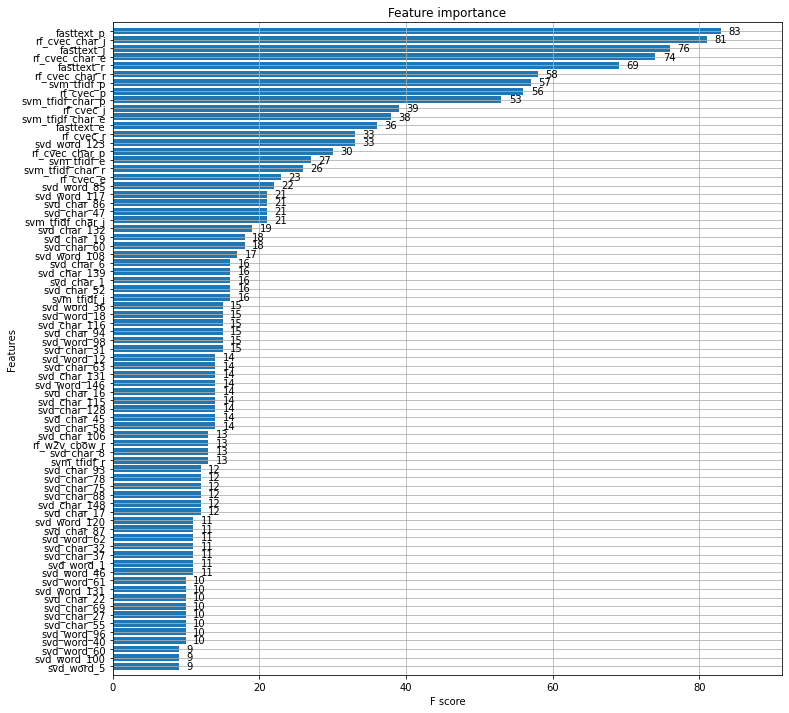

In [48]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=75, height=0.8, ax=ax)
plt.show()

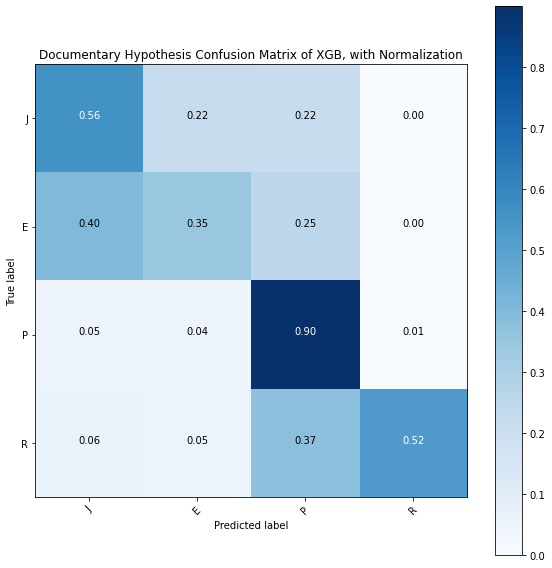

In [49]:
cnf_matrix = sum(cnf_dh_matrices)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['J', 'E', 'P', 'R'], title='Documentary Hypothesis Confusion Matrix of XGB, with Normalization', normalize=True)
plt.show()

Above we see we can clearly identify the P source as they have a strong stylometric signature. We also notice that the classifer struggles to distinguish between the J and E source, as well as between the P and R source. This shows that there is a lack of variance in authorial style between them. This indicates that J and E, as well as P and R may be the same authors. We also see a high degree of misclassification for sources that schollars have traditionally attributed to J and E in favor of the P source. This might be a reason to believe that the P source has expressed their stylometric signature upon the J/E source.

In [50]:
k = 2
n_splits = 5
y_train = y_sh_train
x_train = train_sh_df
x_test = test_sh_df
algo = runXGB

num_rounds = 2000
param = {
    'tree_method': 'gpu_hist',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': k,
    'eta': 0.3,
    'max_depth': 2,
    'min_child_weight': 2,
    'subsample': 1,
    'colsample_bytree': 1, 
    'seed': 5780
}

cv_log_loss = []
cv_accuracy = []
cnf_sh_matrices = []
cnf_hybrid_matrices = []
pred_full_test = 0
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=5780)
pred_train = np.zeros([len(x_train), k])
for y_dh_val, (dev_index, val_index) in zip(y_dh_vals, kf.split(x_train)):
    x_dev, x_val = x_train.loc[dev_index], x_train.loc[val_index]
    y_dev, y_val = y_train[dev_index], y_train[val_index]
    y_pred_val, y_pred_test, model = runXGB(k, num_rounds, param, x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + y_pred_test
    pred_train[val_index, :] = y_pred_val
    cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
    cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    cnf_matrix = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1))
    cnf_sh_matrices.append(cnf_matrix)
    y_pred_val = [2 if x==1 else x for x in np.argmax(y_pred_val, axis=1)] # Shift from sh to dh key for plotting
    cnf_matrix = confusion_matrix(y_dh_val, y_pred_val)
    cnf_hybrid_matrices.append(cnf_matrix)
print('cv log loss : ', cv_log_loss)
print('cv accuracy: ', cv_accuracy)
print('Mean cv log loss : ', np.mean(cv_log_loss))
print('Mean cv accuracy : ', np.mean(cv_accuracy))

[0]	train-mlogloss:0.54707	test-mlogloss:0.55237
[20]	train-mlogloss:0.29395	test-mlogloss:0.34059
[40]	train-mlogloss:0.25371	test-mlogloss:0.35171
[59]	train-mlogloss:0.22541	test-mlogloss:0.35133
[0]	train-mlogloss:0.54732	test-mlogloss:0.55136
[20]	train-mlogloss:0.28664	test-mlogloss:0.35219
[40]	train-mlogloss:0.24486	test-mlogloss:0.36777


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21655	test-mlogloss:0.36901
[0]	train-mlogloss:0.54595	test-mlogloss:0.55380
[20]	train-mlogloss:0.28080	test-mlogloss:0.38673
[40]	train-mlogloss:0.23955	test-mlogloss:0.39778


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[57]	train-mlogloss:0.21287	test-mlogloss:0.40785
[0]	train-mlogloss:0.54799	test-mlogloss:0.54968
[20]	train-mlogloss:0.29600	test-mlogloss:0.32714
[40]	train-mlogloss:0.25724	test-mlogloss:0.32646


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22555	test-mlogloss:0.33814
[68]	train-mlogloss:0.21530	test-mlogloss:0.34171
[0]	train-mlogloss:0.55081	test-mlogloss:0.54862
[20]	train-mlogloss:0.29810	test-mlogloss:0.31601
[40]	train-mlogloss:0.25947	test-mlogloss:0.32567


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.23131	test-mlogloss:0.32751
[65]	train-mlogloss:0.22539	test-mlogloss:0.32641
cv log loss :  [0.3380585836025376, 0.34798705631612514, 0.37820665808549175, 0.3250049746275367, 0.31398551832375476]
cv accuracy:  [0.8569604086845466, 0.855683269476373, 0.842911877394636, 0.8671775223499362, 0.8607918263090677]
Mean cv log loss :  0.3406485581910892
Mean cv accuracy :  0.8567049808429118


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


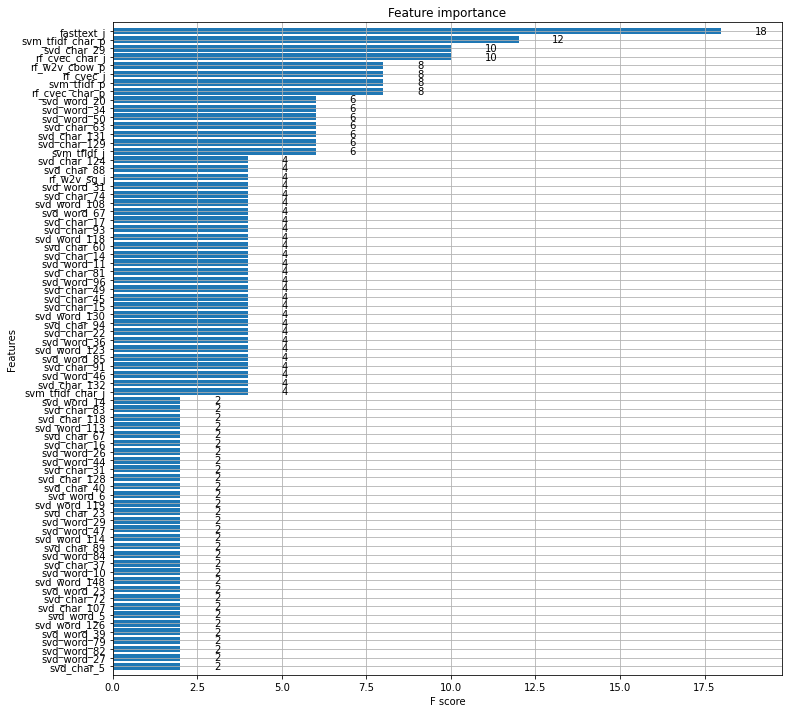

In [51]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=75, height=0.8, ax=ax)
plt.show()

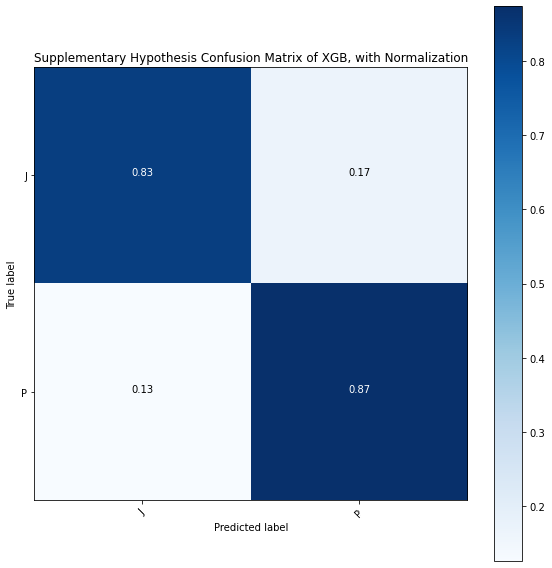

In [52]:
cnf_matrix = sum(cnf_sh_matrices)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['J', 'P'], title='Supplementary Hypothesis Confusion Matrix of XGB, with Normalization', normalize=True)
plt.show()

We see that overall classification log loss has decreased and accuracy has increased. Our results appear to be much more balanced and we are correctly classifying J and P to a much higher degree. There is a slight increase in misclassifications of J as P, this again may be due to the possibility that P has modified J's work and expressed their authorial style onto verses traditionally attributed to J.

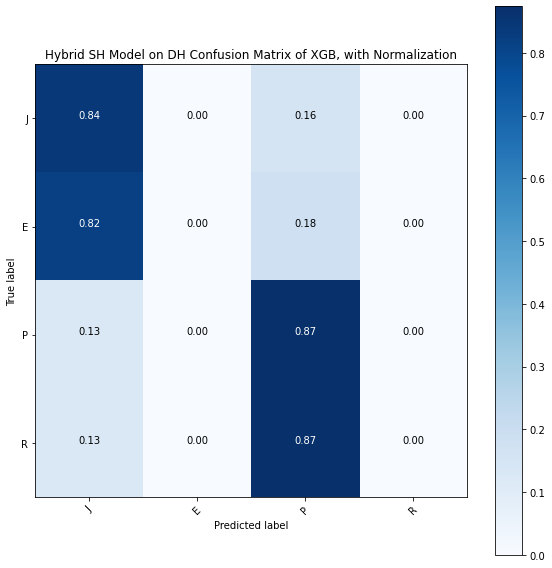

In [53]:
cnf_matrix = sum(cnf_hybrid_matrices)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['J', 'E', 'P', 'R'], title='Hybrid SH Model on DH Confusion Matrix of XGB, with Normalization', normalize=True)
plt.show()

Our assumptions are confirmed when we see that most E verses, when classified by the SH model, are attributed to J. The same is true for R where about 90% of its verses are attributed to P. The perforation of the P source into the J source is still present at a consistent rate of about 20% between verses traditionally attributed to J/E. We call this the J++,P model, where J is influenced (lexically only) by what is now a shadow writer(s) who no longer has a significant stylometric signature. This is the first plus. The second plus comes from P, who has expressed their style onto work traditionally thought to be J's. 

 the authorship of the Torah can best be thought of as “J++,P.” We see that the Torah is written by J, who (from a lexical understanding only) likely drew from what is now a shadow source(s) and left no significant trace of their stylometric signature. This work of J+ was then heavily modified by the P source giving us J++. Then P adds in their own complete contributions to what became the Torah, giving us J++,P.

623408fb0b3a5f8a28bae21a1c19c90678cefae817d67aca863c5e65f4e2bdd4fb4808b6c9cdec5678b5cb8d1061891795c58f315efec44be3ea666815f75427
751b333da354aa3ddddcbcad99bbb26de9172e853d7d277219c00d99dafd69e4519673208b147ef65ed2f5e15814f9b11ba4263d30bddcd058cfba2039c86cd3
0019f3f4bc95dc8d7a3bac9831da493819bae6e7d9364afb535e4bd183c9b7146fb33b6382f8dd8d7d235f16d5cfb6e78ae21855c5e83dd359078d1060ea6a7a

# 